In [14]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()


In [15]:

# Single sample video comparison
def make_comparison_grid(
    scene_rgb, scene_modal_mask,
    gt_amodal_rgb, gt_amodal_mask,
    pred_amodal_rgb, pred_amodal_mask,
    n_frames=24):
    """
    Makes a grid_tensor for a 3 row by 2 column video
    """

    grid_tensors = []
    for i in range(n_frames):
        # Select the i-th frame for each tensor
        scene_rgb_frame = scene_rgb[:, i]                 # (3, H, W)
        scene_mask_frame = scene_modal_mask[:, i]         # (1 or 3, H, W)
        gt_rgb_frame = gt_amodal_rgb[:, i]                # (3, H, W)
        gt_mask_frame = gt_amodal_mask[:, i]              # (1 or 3, H, W)
        pred_rgb_frame = pred_amodal_rgb[:, i]            # (3, H, W)
        pred_mask_frame = pred_amodal_mask[:, i]          # (1 or 3, H, W)

        # If mask is single-channel, repeat to 3 channels for visualization
        if scene_mask_frame.shape[0] == 1:
            scene_mask_frame = scene_mask_frame.repeat(3, 1, 1)
        if gt_mask_frame.shape[0] == 1:
            gt_mask_frame = gt_mask_frame.repeat(3, 1, 1)
        if pred_mask_frame.shape[0] == 1:
            pred_mask_frame = pred_mask_frame.repeat(3, 1, 1)

        # Top row: Scene RGB | Scene modal mask
        top_row = [scene_rgb_frame, scene_mask_frame]
        # Middle row: GT amodal RGB | GT amodal mask
        middle_row = [gt_rgb_frame, gt_mask_frame]
        # Bottom row: Pred amodal RGB | Pred amodal mask
        bottom_row = [pred_rgb_frame, pred_mask_frame]

        # Stack all rows horizontally (2 columns per row, 3 rows)
        grid = top_row + middle_row + bottom_row  # [6 tensors]
        grid_img = make_grid(grid, nrow=2, padding=2, pad_value=127)
        grid_tensors.append(grid_img)
    return grid_tensors


In [16]:
# Single sample video comparison
def make_model_comparison_grid(scene_rgb, scene_modal_mask,
                               gt_amodal_rgb, gt_amodal_mask,
                               pred1_amodal_rgb, pred1_amodal_mask,
                               pred2_amodal_rgb, pred2_amodal_mask,
                               padding=2, pad_value=127, n_per_row=2):
    """
    Makes a grid_tensor for a 4 row by 2 column video
    Compares inputs and ground truth to output from two models
    """
    # Infer frames from the second dim
    n_frames = scene_rgb.shape[1]
    print(n_frames)
    grid_tensors = []
    for i in range(n_frames):
        # Select the i-th frame for each tensor
        scene_rgb_frame = scene_rgb[:, i]                 # (3, H, W)
        scene_mask_frame = scene_modal_mask[:, i]         # (1 or 3, H, W)
        gt_rgb_frame = gt_amodal_rgb[:, i]                # (3, H, W)
        gt_mask_frame = gt_amodal_mask[:, i]              # (1 or 3, H, W)
        pred1_rgb_frame = pred1_amodal_rgb[:, i]            # (3, H, W)
        pred1_amask_frame = pred1_amodal_mask[:, i]          # (1 or 3, H, W)
        pred2_rgb_frame = pred2_amodal_rgb[:, i]            # (3, H, W)
        pred2_amask_frame = pred2_amodal_mask[:, i]          # (1 or 3, H, W)

        # If mask is single-channel, repeat to 3 channels for visualization
        if scene_mask_frame.shape[0] == 1:
            scene_mask_frame = scene_mask_frame.repeat(3, 1, 1)
        if gt_mask_frame.shape[0] == 1:
            gt_mask_frame = gt_mask_frame.repeat(3, 1, 1)
        if pred1_amask_frame.shape[0] == 1:
            pred1_amask_frame = pred1_amask_frame.repeat(3, 1, 1)
        if pred2_amask_frame.shape[0] == 1:
            pred2_amask_frame = pred2_amask_frame.repeat(3, 1, 1)

        # Top row: Scene RGB | Scene modal mask
        row1 = [scene_rgb_frame, scene_mask_frame, gt_rgb_frame, gt_mask_frame]
        # Middle row: GT amodal RGB | GT amodal mask
        row2 = [pred1_rgb_frame, pred1_amask_frame, pred2_rgb_frame, pred2_amask_frame]
        # # Bottom row: Pred Mod1 amodal RGB | Pred Mod1 amodal mask
        # row3 = []
        # # Bottom row: Pred Mod2 amodal RGB | Pred Mod2 amodal mask
        # row4 = []

        # Stack all rows horizontally (2 columns per row, 4 rows)
        grid = row1 + row2  # [8 tensors]
        # nrow is num of images per row
        grid_img = make_grid(grid, nrow=n_per_row, padding=padding, pad_value=pad_value)
        grid_tensors.append(grid_img)
    return grid_tensors


In [17]:
# Quick video
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})


# Make matplotlib video with titles
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

def make_grid_video_with_titles(grid_tensors, 
                                panel_titles=[['Input RGB', 'Input Modal Mask'],
                                              ['True Amodal RGB', 'True Amodal Mask'],
                                              ['Pred Amodal RGB', 'Pred Amodal Mask']], 
                                nrows=3, ncols=2, figsize=(8, 12), 
                                title_fontsize=12,
                                interval=200, save_path=None):
    """
    Writes a 2-column, 3-row video. 

    grid_tensors: list of torch.Tensor, each of shape (3, H, W), values in [0,1] or [0,255]
    panel_titles: 2D list of strings, shape (nrows, ncols)
    interval: time between frames in ms
    save_path: if not None, saves animation to this path (e.g., 'output.mp4')
    """
    # Prepare figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes if isinstance(axes, np.ndarray) else np.array([[axes]])

    assert np.array(panel_titles).shape == axes.shape

    # Compute panel height and width from first frame
    img = grid_tensors[0].cpu()
    # Always convert to uint8 for display
    if img.dtype != torch.uint8:
        img = (img * 255).clamp(0, 255).byte()
    img_np = img.permute(1, 2, 0).numpy()  # (H, W, 3)

    # Debug: print min/max for first frame
    print(f"First frame min: {img_np.min()}, max: {img_np.max()}, dtype: {img_np.dtype}")

    H, W, _ = img_np.shape
    panel_h = H // nrows
    panel_w = W // ncols

    # Set titles and initialize images
    ims = []
    for i in range(nrows):
        row = []
        for j in range(ncols):
            ax = axes[i, j]
            ax.set_title(panel_titles[i][j], fontsize=title_fontsize)
            ax.axis('off')
            # Dummy initial image
            panel = img_np[i*panel_h:(i+1)*panel_h, j*panel_w:(j+1)*panel_w]
            im = ax.imshow(panel)
            row.append(im)
        ims.append(row)

    def update(frame_idx):
        img = grid_tensors[frame_idx].cpu()
        if img.dtype != torch.uint8:
            img = (img * 255).clamp(0, 255).byte()
        img_np = img.permute(1, 2, 0).numpy()
        for i in range(nrows):
            for j in range(ncols):
                y0, y1 = i * panel_h, (i + 1) * panel_h
                x0, x1 = j * panel_w, (j + 1) * panel_w
                panel = img_np[y0:y1, x0:x1]
                ims[i][j].set_data(panel)
        return sum(ims, [])

    ani = animation.FuncAnimation(fig, update, frames=len(grid_tensors), interval=interval, blit=False)
    plt.tight_layout()
    if save_path is not None:
        ani.save(save_path, writer='ffmpeg')
    else:
        plt.show()



## make figures

In [4]:
import matplotlib.pyplot as plt

In [5]:
import sys
sys.path.append("../load_data")
from load_dataset import MOVi_Dataset, MOVi_ImageDataset, MOVi_Dataset_SmartSelect
from torch.utils.data import DataLoader

In [6]:
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"
ROOT_PATH = "/p/lustre2/marcou1/dsc2025/dsc25_data"
ROOT_PATH = "/usr/workspace/dssi-dsc/subset_data"

In [23]:
# Arguments
batch_size = 4
mask_content_preds = True
n_workers = 1
n_epochs = 10
n_frames = 8

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_SmartSelect(split = 'train', 
                             n_frames = n_frames,
                             n_samples = 32, 
                             root=ROOT_PATH,
                             min_modal_pixels_visible = 10,
                             min_occ_rate = 0.5,
                             max_occ_rate = 0.9)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset_SmartSelect(split = 'test', 
                           n_frames = n_frames,
                           n_samples = 8,
                          root=ROOT_PATH,
                          min_modal_pixels_visible = 10,
                             min_occ_rate = 0.5,
                             max_occ_rate = 0.9
                          )
val_dataloader = DataLoader(val_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)
# val_dataset = train_dataset

# val_dataloader = train_dataloader



Dataset init on train
Init data top dir: /usr/workspace/dssi-dsc/subset_data/train/
Dataset init on test
Init data top dir: /usr/workspace/dssi-dsc/subset_data/test/


In [24]:
sample = next(iter(val_dataset))

In [25]:
grid_tensors = make_model_comparison_grid(scene_rgb=sample['frames'], 
                           scene_modal_mask=sample['modal_masks'],
                               gt_amodal_rgb=sample['amodal_content'], 
                               gt_amodal_mask=sample['amodal_masks'],
                               pred1_amodal_rgb=sample['amodal_content'], 
                               pred1_amodal_mask=sample['amodal_masks'],
                               pred2_amodal_rgb=sample['amodal_content'], 
                               pred2_amodal_mask=sample['amodal_masks'], n_per_row=4)

8


In [13]:
grid_tensors[0].shape

torch.Size([3, 1034, 518])

First frame min: 0, max: 255, dtype: uint8


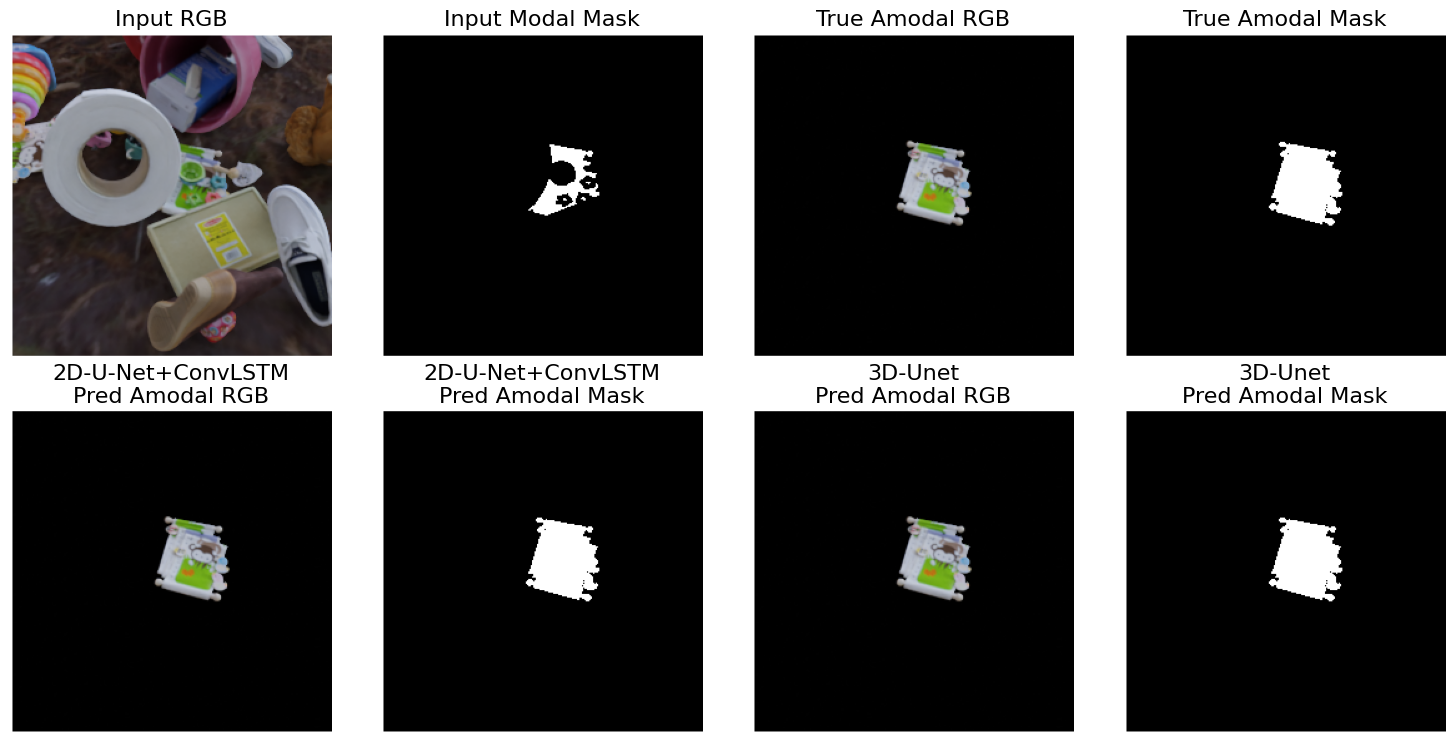

In [29]:
metadata = sample['metadata']
outpath = f"/p/lustre2/marcou1/dsc2025/test_videos/model_comparison_{metadata['scene_id']}_{metadata['cam_id']}_obj{metadata['obj_id']}.gif"
make_grid_video_with_titles(grid_tensors,
                            panel_titles=[['Input RGB', 'Input Modal Mask', 'True Amodal RGB', 'True Amodal Mask'],
                                              ['2D-U-Net+ConvLSTM\nPred Amodal RGB', '2D-U-Net+ConvLSTM\nPred Amodal Mask', '3D-Unet\nPred Amodal RGB', '3D-Unet\nPred Amodal Mask']],
                            nrows=2, ncols=4,
                            interval=200, 
                            save_path=outpath, figsize=(15, 7.5), title_fontsize=16)